In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import curve_fit
from typing import List
import matplotlib.ticker as ticker


# plt.style.use("bmh")
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.grid'] = True
# plt.rcParams.keys()

In [2]:
def lineal(x,a,b): return a*x+b

In [3]:
def cargar_datos(file_name : str, pow_measure = False) -> List[np.ndarray]:
    
    # Cargamos los datos
    with open(file_name, "rb") as f:
        dic = pickle.load(f)
    # Hago una lista con los valores de offset que alimentamos con el generador de funciones
    offs_values_keys = list(dic.keys())
    # Valores de corriente en mA
    corr_values = np.array([np.mean(dic[offset]["V_1"])*1000 for offset in offs_values_keys])
    # Varianza de la corriente
    corr_err_values = np.array([np.std(dic[offset]["V_1"])*1000 for offset in offs_values_keys])
    # Verdaderos valores de continua
    offs_true_values = np.array([np.mean(dic[offset]["V_2"]) for offset in offs_values_keys])
    # Le sacamos la "V" a las keys
    offs_values = np.array([float(offset[:-1]) for offset in offs_values_keys])

    # Creamos una lista para guardar todos los datos que nos interesan
    lista_mediciones = [offs_values, offs_true_values, corr_values, corr_err_values]

    # Mediciones de la potencia
    if pow_measure:
        POW_values = [np.mean(dic[offset]["POW"])*1000 for offset in offs_values_keys] # Potencia en mW
        POW_var_values = [np.std(dic[offset]["POW"])*1000 for offset in offs_values_keys] # Potencia en mW

        lista_mediciones.append(POW_values)
        lista_mediciones.append(POW_var_values)

    return lista_mediciones

# Fotodetectores continua

In [3]:
file_name = '../mediciones/D.D/Fotodetectores/Fotodetector A - Barrido offset.pickle'

dic = pickle.load(open(file_name, "rb"))

In [4]:
corr, V_fotodetector = [], []
for key in dic.keys():
    corr.append(np.mean(dic[key]["V_1"]))
    V_fotodetector.append(np.mean(dic[key]["V_2"]))

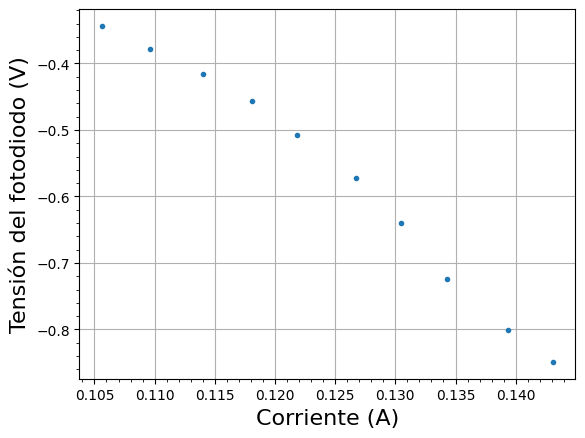

In [5]:
plt.plot(np.abs(corr),V_fotodetector,".")
plt.xlabel("Corriente (A)")
plt.ylabel("Tensión del fotodiodo (V)")
plt.show()

# Medición de linealidad de la resta girando un polarizador


Escala canal 1 = 50 mV

Escala canal 2 = 100 mV

Escala temporal = 25 ms

Ángulo lámina de onda = 282° ± 2°

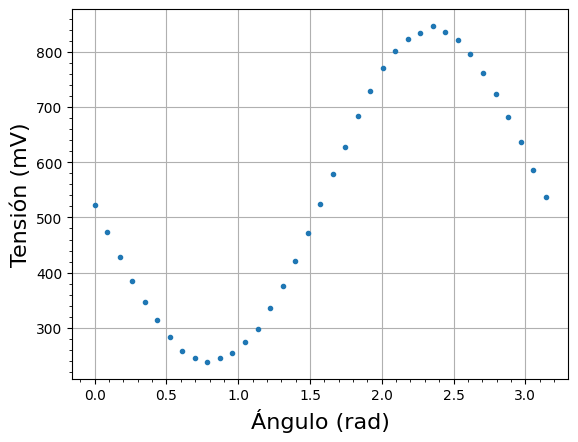

In [4]:
corriente_laser = 125.9 # mA

angulo_polarizador = np.radians([0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,
                                 95,100,105,110,115,120,125,130,135,140,145,150,155,160,165,170,175,180]) # Angulo asado a radianes 

tension_resta = [521.7, 473.1, 428.2,384.7,346.8,314.3,282.6,257.5,244.5,238.3,244.6,254.6,
                 273.5,298.6,335.2,375.3,420.2,471.2,524.4,578.5,627.9,683.2,729.1,771.2,802.3,
                 823.2,834.3,846.9,835.3,821.4,795.4,761.2,723.7,681.3,636.8,585.7,537.3] # mV

plt.plot(angulo_polarizador, tension_resta, ".")
plt.xlabel("Ángulo (rad)")
plt.ylabel("Tensión (mV)")
plt.show()

In [5]:
def func(x, I0,phi,offset):
    return I0*np.sin(2*x+phi)+offset

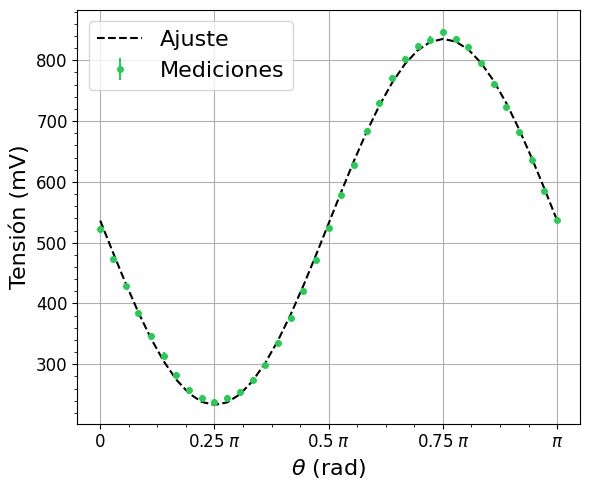

In [6]:
popt, pcov = curve_fit(func, angulo_polarizador, tension_resta)

fig, ax = plt.subplots(ncols = 1, figsize = (6,5))
ax.plot(angulo_polarizador, func(angulo_polarizador,*popt), label = "Ajuste", ls = "--", c = "k")
ax.errorbar(angulo_polarizador, tension_resta, yerr = 5*np.ones(len(angulo_polarizador)), fmt = ".", color = "#24ce52", ms = 8, label = "Mediciones")
ax.set_xlabel(r"$\theta$"+ " (rad)")
ax.set_ylabel("Tensión (mV)")

pi_fraction_labels = [rf"${i/4}\; \pi$" if i//4 != i/4
                      else "0" if i ==0
                      else r"$\pi$" for i in range(0, 5)]  # Adjust the range as needed
ax.set_xticks(np.linspace(0, max(angulo_polarizador), 5))
ax.set_xticklabels(pi_fraction_labels)
ax.tick_params(labelsize = 12)
ax.legend()
plt.tight_layout()
# plt.savefig('../imagenes/Fotodetectores/resta_malus.png')
plt.show()

In [7]:
popt

array([301.12341682,  65.96612552, 534.10258744])

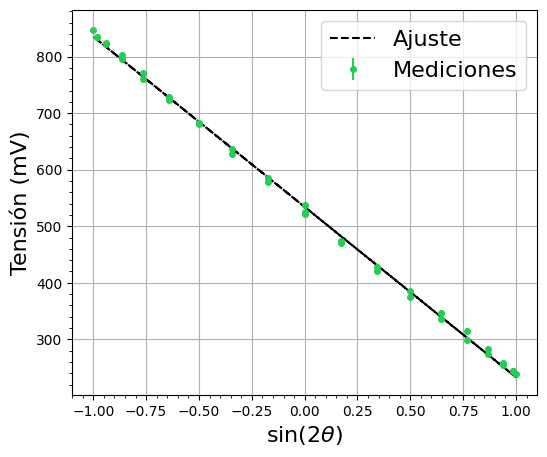

In [15]:
seno = np.sin(2*angulo_polarizador)

popt, pcov = curve_fit(lineal, seno, tension_resta)

fig, ax = plt.subplots(ncols = 1, figsize = (6,5))
ax.plot(seno, lineal(seno,*popt), label = "Ajuste",  ls = "--", c = "k")
ax.errorbar(seno, tension_resta, yerr = 5*np.ones(len(angulo_polarizador)), fmt = ".", color = "#24ce52", ms = 8, label = "Mediciones")
ax.set_xlabel(r"$\sin(2\theta)$")
ax.set_ylabel("Tensión (mV)")
ax.legend()
plt.savefig('../imagenes/Fotodetectores/resta_malus.png')
plt.show()

In [11]:
print(popt)

[-301.11534894  534.16216216]


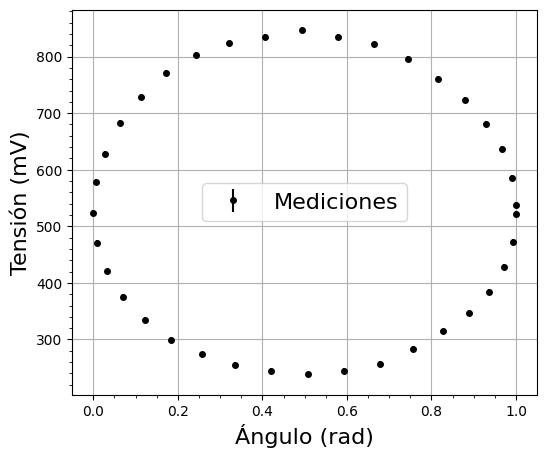

In [9]:
coseno = np.cos(angulo_polarizador+65.96612552)**2

fig, ax = plt.subplots(ncols = 1, figsize = (6,5))
ax.errorbar(coseno, tension_resta, yerr = 5*np.ones(len(angulo_polarizador)), fmt = ".k", ms = 8, label = "Mediciones")
ax.set_xlabel("Ángulo (rad)")
ax.set_ylabel("Tensión (mV)")
ax.legend()
plt.show()

# "Responsividad" fotodiodos en corriente del láser

Escalas de los canales del osciloscopio: ambas en 50 mV

In [14]:
file_name = '../mediciones/D.D/Fotodiodos/Fotodiodo A - Barrido continua - R50.pickle'

offs_values, V_fotodiodo_A, corr_values_A, corr_est_err = cargar_datos(file_name, pow_measure = False)

file_name = '../mediciones/D.D/Fotodiodos/Fotodiodo B - Barrido continua - R50.pickle'

offs_values, V_fotodiodo_B, corr_values_B, corr_est_err = cargar_datos(file_name, pow_measure = False)

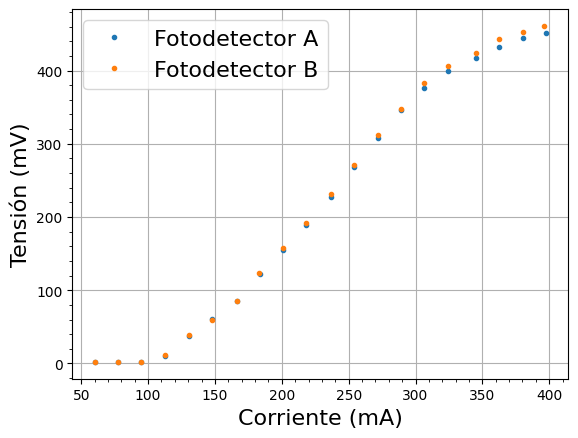

In [15]:
plt.plot(-corr_values_A, 1000*V_fotodiodo_A,".", label = "Fotodetector A")
plt.plot(-corr_values_B, 1000*V_fotodiodo_B,".", label = "Fotodetector B")

plt.xlabel("Corriente (mA)")
plt.ylabel("Tensión (mV)")

plt.legend()
plt.show()

Barrido fino

In [16]:
file_name = '../mediciones/D.D/Fotodiodos/Fotodiodo A - Barrido continua - R50 - fino.pickle'

offs_values, V_fotodiodo_A, corr_values_A, corr_est_err = cargar_datos(file_name, pow_measure = False)

file_name = '../mediciones/D.D/Fotodiodos/Fotodiodo B - Barrido continua - R50 - fino.pickle'

offs_values, V_fotodiodo_B, corr_values_B, corr_est_err = cargar_datos(file_name, pow_measure = False)


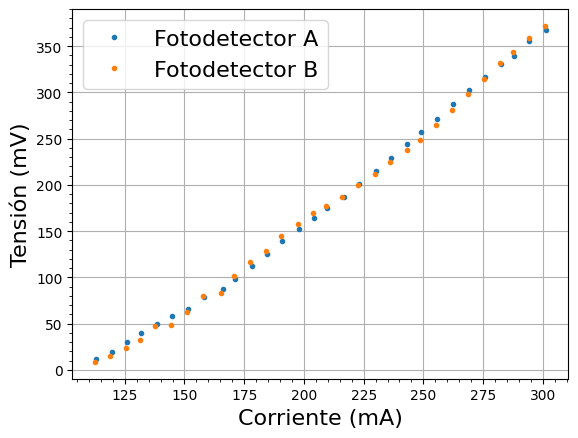

In [17]:
plt.plot(-corr_values_A, 1000*V_fotodiodo_A,".", label = "Fotodetector A")
plt.plot(-corr_values_B, 1000*V_fotodiodo_B,".", label = "Fotodetector B")

plt.xlabel("Corriente (mA)")
plt.ylabel("Tensión (mV)")

plt.legend()
plt.show()

# "Responsividad" (Tensión) de los fotodiodos en función de la potencia incidente

Resistencias de la resta:
1er op amp: 10k
medio: 1 k
2do op amp: 10 k

In [4]:
dic_A = pickle.load(open("../mediciones/D.D/Fotodiodos/Fotodiodo A - Tension en funcion de potencia - Fotodetectores prendidos.pickle", "rb"))
dic_B = pickle.load(open("../mediciones/D.D/Fotodiodos/Fotodiodo B - Tension en funcion de potencia - Fotodetectores prendidos.pickle", "rb"))

In [5]:
V_A = [np.mean(dic_A[V]["V_2"]-dic_A[V]["V_1"])for V in dic_A.keys()]
POW_A = [np.mean(dic_A[V]["POW"])*1000 for V in dic_A.keys()]

V_B = [np.mean(dic_B[V]["V_2"]-dic_B[V]["V_1"]) for V in dic_B.keys()]
POW_B = [np.mean(dic_B[V]["POW"])*1000 for V in dic_B.keys()]

In [6]:
V_A_sort = np.array([x for _, x in sorted(zip(POW_A, V_A), key=lambda pair: pair[0])])
POW_A_sort = np.array([y for y, _ in sorted(zip(POW_A, V_A), key=lambda pair: pair[0])])

V_B_sort = np.array([x for _, x in sorted(zip(POW_B, V_B), key=lambda pair: pair[0])])
POW_B_sort = np.array([y for y, _ in sorted(zip(POW_B, V_B), key=lambda pair: pair[0])])

popt_A, pcov_A = curve_fit(lineal, POW_A_sort[:9], V_A_sort[:9])
popt_B, pcov_B = curve_fit(lineal, POW_B_sort[:8], V_B_sort[:8])

In [7]:
popt_A, popt_B

(array([-0.30050608,  4.98492562]), array([ 0.32205252, -5.21061773]))

In [9]:
np.sqrt(np.abs(pcov_A)),np.sqrt(np.abs(pcov_B))

(array([[0.01116964, 0.03185981],
        [0.03185981, 0.1074249 ]]),
 array([[0.00984582, 0.02928069],
        [0.02928069, 0.10059561]]))

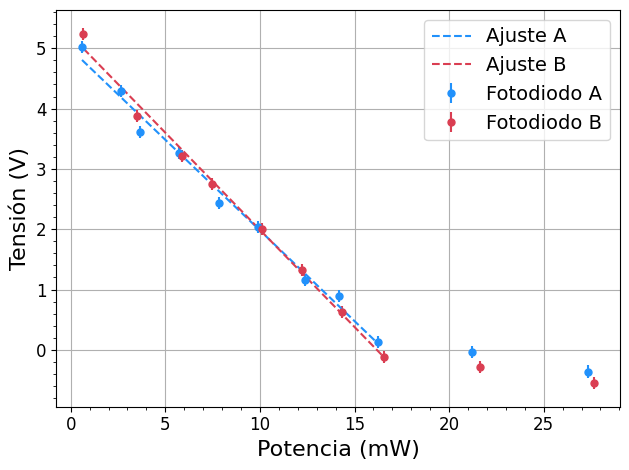

In [8]:
plt.errorbar(POW_A,np.array(V_A), yerr = 0.1, fmt = ".", c = "#2191FB", label = "Fotodiodo A", ms = 10)
plt.errorbar(POW_B,-np.array(V_B), yerr = 0.1, fmt =".", c = "#DA3E52", label = "Fotodiodo B", ms = 10)#"#00f7ff"

plt.plot(POW_A_sort[:9], lineal(POW_A_sort[:9],*popt_A), c = "#2191FB", ls = "--", label = "Ajuste A")
plt.plot(POW_B_sort[:8], -lineal(POW_B_sort[:8],*popt_B), c = "#DA3E52", ls = "--", label = "Ajuste B")


plt.xlabel("Potencia (mW)")
plt.ylabel("Tensión (V)")
plt.legend(loc = "upper right", fontsize = 14)
plt.tick_params(labelsize = 12)
plt.tight_layout()
# plt.savefig('../imagenes/Fotodetectores/responsitivity_fotodiodos.png')
plt.show()

# Analisis en función de la potencia del láser (para chequear el PBS)

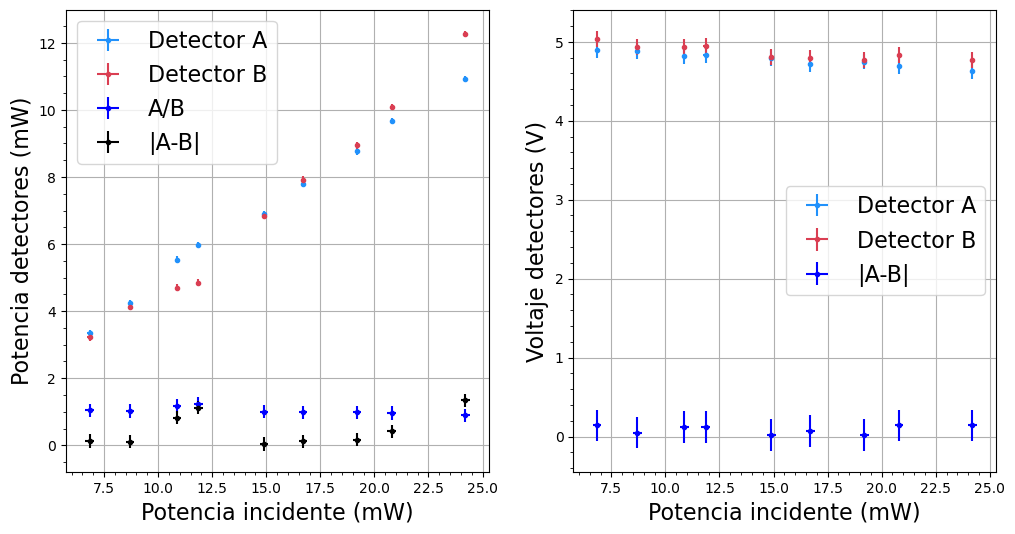

In [14]:
potencia_total = np.array([14.9, 16.7, 19.2, 20.8, 24.2, 11.86, 10.88, 8.7, 6.83])
potencia_A = np.array([6.89, 7.8, 8.77, 9.67, 10.92, 5.97, 5.53, 4.24, 3.35])
potencia_B = np.array([6.85, 7.92, 8.94, 10.09, 12.26, 4.85, 4.7, 4.13, 3.22])
voltaje_A = np.array([4.79, 4.72, 4.75, 4.69, 4.63, 4.83, 4.82, 4.88, 4.9])
voltaje_B = np.array([4.81, 4.79, 4.77, 4.83, 4.77, 4.95, 4.94, 4.93, 5.04])

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

axes[0].errorbar(potencia_total, potencia_A, xerr=0.1, yerr=0.1, c='#2191FB', fmt='.', label='Detector A')
axes[0].errorbar(potencia_total, potencia_B, xerr=0.1, yerr=0.1, c='#DA3E52', fmt='.', label='Detector B')
axes[0].errorbar(potencia_total, potencia_A/potencia_B, xerr=0.2, yerr=0.2, c='b', fmt='.', label='A/B')
axes[0].errorbar(potencia_total, np.abs(potencia_A-potencia_B), xerr=0.2, yerr=0.2, c='k', fmt='.', label='|A-B|')  
axes[0].set_xlabel('Potencia incidente (mW)')
axes[0].set_ylabel('Potencia detectores (mW)')
axes[0].legend()

axes[1].errorbar(potencia_total, voltaje_A, xerr=0.1, yerr=0.1, c='#2191FB', fmt='.', label='Detector A')
axes[1].errorbar(potencia_total, voltaje_B, xerr=0.1, yerr=0.1, c='#DA3E52', fmt='.', label='Detector B')
axes[1].errorbar(potencia_total, np.abs(voltaje_B-voltaje_A), xerr=0.2, yerr=0.2, c='b', fmt='.', label='|A-B|')
axes[1].set_xlabel('Potencia incidente (mW)')
axes[1].set_ylabel('Voltaje detectores (V)')
axes[1].legend()
plt.show()


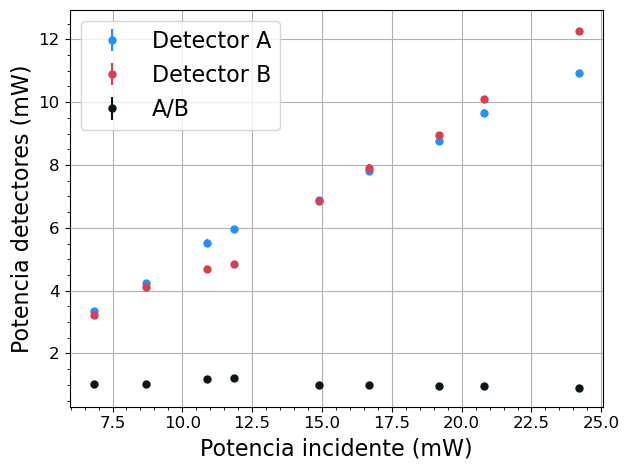

In [27]:
plt.errorbar(potencia_total, potencia_A, yerr=0.1, c='#2191FB', fmt='.', label='Detector A', ms = 10)
plt.errorbar(potencia_total, potencia_B, yerr=0.1, c='#DA3E52', fmt='.', label='Detector B', ms = 10)
plt.errorbar(potencia_total, potencia_A/potencia_B, yerr=np.sqrt((potencia_A*0.1/(potencia_B**2))**2+(0.1/potencia_B)**2), c='#0C1713', fmt='.', label='A/B', ms = 10)
# plt.errorbar(potencia_total, np.abs(potencia_A-potencia_B), xerr=0.2, yerr=0.2, c='b', fmt='.', label='|A-B|')  
plt.xlabel('Potencia incidente (mW)')
plt.ylabel('Potencia detectores (mW)')
plt.legend()
plt.tick_params(labelsize = 12)
plt.tight_layout()
# plt.savefig('../imagenes/Fotodetectores/potencia_pbs.png')
plt.show()

In [119]:
np.mean(potencia_A/potencia_B), np.std(potencia_A/potencia_B, ddof = 1)

(1.032808774510243, 0.10692837959135976)

In [102]:
suma_potencias = potencia_A + potencia_B
ratio_A = potencia_A/suma_potencias
ratio_B = potencia_B/suma_potencias

print(f'Ratio A = {np.round(np.mean(ratio_A), 2)} +- {np.round(np.std(ratio_A), 2)}')
print(f'Ratio B = {np.round(np.mean(ratio_B), 2)} +- {np.round(np.std(ratio_B), 2)}')

Ratio A = 0.51 +- 0.02
Ratio B = 0.49 +- 0.02


# Análisis de tensión en los monitores en función de la potencia incidente

In [17]:
POW_A = [6.15,7.04,8.44,9.37,5.84,5.00,4.09,3.30,2.58,1.97]
V_A = np.array([-1.860,-2.065,-2.34,-2.55,-1.756,-1.575,-1.372,-1.2,-1.042,-0.910]) # Para pasar a mV
POW_B = [5.43,6.31,9.03,10.15,6.02,5.06,4.08,3.2,2.39,1.68]
V_B = np.array([-1.48,-1.572,-2.06,-2.277,-1.5,-1.32,-1.142,-0.991,-0.8385,-0.706]) # Para pasar a mV

V_A_err = np.ones(len(V_A))*15.625/1000 # Se midio en escala de 500 mV, por lo que en 8 cuadrados entran 4 V / 2^8 bits
V_B_err = np.ones(len(V_B))*15.625/1000

popt_A, pcov_A = curve_fit(lineal, POW_A, V_A, sigma=V_A_err, absolute_sigma= True)
popt_B, pcov_B = curve_fit(lineal, POW_B, V_B, sigma=V_B_err, absolute_sigma= True)

POW_ajuste = np.linspace(np.min([POW_A,POW_B]), np.max([POW_A,POW_B]),100)

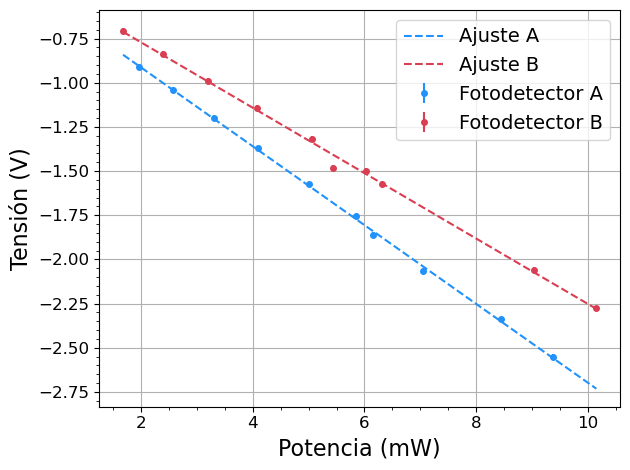

In [25]:
fig, ax = plt.subplots(figsize=(6.4,4.8))
ax.errorbar(POW_A, V_A, yerr = V_A_err, fmt = ".", color = "#2191FB", label = "Fotodetector A", ms = 8)
ax.plot(POW_ajuste, lineal(POW_ajuste,*popt_A), c = "#2191FB", ls = "--", label = "Ajuste A")
ax.errorbar(POW_B,V_B, yerr = V_B_err, fmt = ".", color = "#DA3E52", label = "Fotodetector B", ms = 8)
ax.plot(POW_ajuste, lineal(POW_ajuste,*popt_B), c = "#DA3E52", ls = "--", label = "Ajuste B")

ax.set_xlabel("Potencia (mW)", fontsize = 16)
ax.set_ylabel("Tensión (V)", fontsize = 16)
ax.legend(fontsize = 14)
ax.tick_params(labelsize = 12)
plt.tight_layout()
# plt.savefig('../imagenes/Fotodetectores/monitores_individuales.png')
plt.show()

In [91]:
popt_A, popt_B

(array([-0.22317251, -0.46677825]), array([-0.18516003, -0.40082123]))

In [92]:
popt_A[1]-popt_B[1] # Diferencia entre canales

-0.0659570205198794

In [93]:
np.sqrt(np.abs(pcov_A)),np.sqrt(np.abs(pcov_B))

(array([[0.00211755, 0.00491071],
        [0.00491071, 0.0124139 ]]),
 array([[0.00191596, 0.00442541],
        [0.00442541, 0.01135324]]))

# Análisis de la resta en función de la potencia incidente

In [1]:
# datos de la lineal P-I
a = -0.15707846274521509 
b = -18.338496871809042

def P(I):
    return a*I + b

file_name = f'../mediciones/D.D/Fotodetectores/Resta barrido continua.pickle'

# offs_values, V_fotodiodo_A, corr_values_A, corr_est_err = cargar_datos(file_name, pow_measure = False)

In [6]:
dic = pickle.load(open(file_name, "rb"))

In [17]:
corr = np.array([np.mean(dic[key]["V_1"]) for key in dic.keys()])
resta = np.array([np.mean(dic[key]["V_2"]) for key in dic.keys()])
potencia = P(corr*1000)

Text(0.5, 0, 'Potencia incidente (mW)')

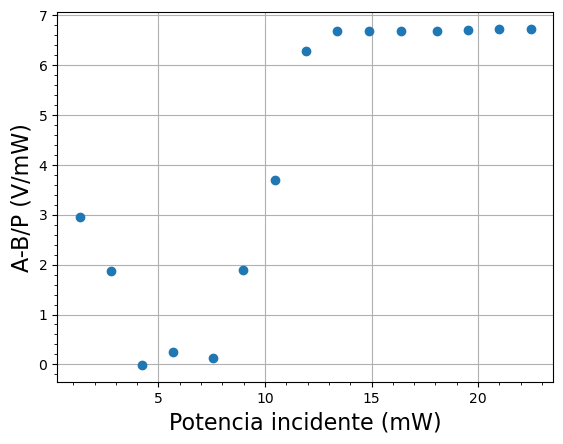

In [23]:
plt.plot(potencia,resta, 'o')
plt.ylabel('A-B/P (V/mW)')
plt.xlabel('Potencia incidente (mW)')